In [1]:
import torch
import torch.nn as nn
import torchmetrics

from datetime import date

import sys; sys.path.append("../")
from models.model_SimpleUNet import SimpleUnet

from utils import (
    load_data,
    training_loop,
    TiledMSE,
    data_protocol_bd
)


In [2]:
# define training hyper-parameters 
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 64
num_workers = 6

In [3]:
# define dataset folder 
DATA_FOLDER = '/home/lcamilleri/data/s12_buildings/data_patches/'

In [4]:
# define model & criterion
model =  SimpleUnet(input_dim=10, output_dim=1) 
criterion = nn.MSELoss() 
lr_scheduler = 'reduce_on_plateau'

In [5]:
# define save folder location
NAME = model.__class__.__name__
OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}'
if lr_scheduler is not None:
    OUTPUT_FOLDER = f'trained_models/{date.today().strftime("%d%m%Y")}_{NAME}_{lr_scheduler}'
    if lr_scheduler == 'reduce_on_plateau':
        LEARNING_RATE = LEARNING_RATE / 100000 # for warmup start

In [6]:
# attach model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# create a dataset
# split_percentage defines the % of samples taken from 
# each specified region ... example split_percentage = 0.2 
# will create a training set consisting of only 20% of the 
# images from each region.

x_train, y_train, x_val, y_val, x_test, y_test = data_protocol_bd.protocol_split(folder=DATA_FOLDER,
                                                                                     split_percentage=0.2)


In [8]:
# create dataloaders for training
dl_train, dl_val, dl_test = load_data(x_train, y_train, x_val, y_val, x_test, y_test,
                                      with_augmentations=False,
                                      num_workers=num_workers,
                                      batch_size=BATCH_SIZE,
                                      encoder_only=False,
                                      )

In [9]:
# define some torch metrics
wmape = torchmetrics.WeightedMeanAbsolutePercentageError(); wmape.__name__ = "wmape"
mae = torchmetrics.MeanAbsoluteError(); mae.__name__ = "mae"
mse = torchmetrics.MeanSquaredError(); mse.__name__ = "mse"

In [10]:
# run training loop
training_loop(
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        model=model,
        criterion=criterion,
        device=device,
        metrics=[
            mse.to(device),
            wmape.to(device),
            mae.to(device),
        ],
        lr_scheduler=lr_scheduler,
        train_loader=dl_train,
        val_loader=dl_val,
        test_loader=dl_test,
        name=NAME,
        out_folder=OUTPUT_FOLDER,
        predict_func=None,
    )

Starting training...



Epoch 1/100: 100%|█| 222/222 [00:16<00:00, 13.29it/s, loss=0.1315, mse=0.1315, wmape=2.0275, mae=0.2740, val_lo
Epoch 2/100: 100%|█| 222/222 [00:14<00:00, 15.53it/s, loss=0.1311, mse=0.1311, wmape=2.0299, mae=0.2738, val_lo
Epoch 3/100: 100%|█| 222/222 [00:14<00:00, 15.53it/s, loss=0.1280, mse=0.1280, wmape=2.0072, mae=0.2708, val_lo
Epoch 4/100: 100%|█| 222/222 [00:14<00:00, 15.54it/s, loss=0.1059, mse=0.1059, wmape=1.8312, mae=0.2475, val_lo
Epoch 5/100: 100%|█| 222/222 [00:14<00:00, 15.52it/s, loss=0.0598, mse=0.0598, wmape=1.2422, mae=0.1679, val_lo


Warmup finished


Epoch 6/100: 100%|█| 222/222 [00:14<00:00, 15.53it/s, loss=0.0450, mse=0.0450, wmape=0.9763, mae=0.1322, val_lo
Epoch 7/100: 100%|█| 222/222 [00:14<00:00, 15.61it/s, loss=0.0410, mse=0.0410, wmape=0.9133, mae=0.1235, val_lo
Epoch 8/100: 100%|█| 222/222 [00:14<00:00, 15.48it/s, loss=0.0391, mse=0.0391, wmape=0.8814, mae=0.1193, val_lo
Epoch 9/100: 100%|█| 222/222 [00:14<00:00, 15.45it/s, loss=0.0376, mse=0.0376, wmape=0.8582, mae=0.1161, val_lo
Epoch 10/100: 100%|█| 222/222 [00:14<00:00, 15.62it/s, loss=0.0364, mse=0.0364, wmape=0.8373, mae=0.1134, val_l
Epoch 11/100: 100%|█| 222/222 [00:14<00:00, 15.53it/s, loss=0.0355, mse=0.0355, wmape=0.8221, mae=0.1112, val_l
Epoch 12/100: 100%|█| 222/222 [00:14<00:00, 15.51it/s, loss=0.0344, mse=0.0344, wmape=0.8034, mae=0.1087, val_l
Epoch 13/100: 100%|█| 222/222 [00:14<00:00, 15.48it/s, loss=0.0334, mse=0.0334, wmape=0.7867, mae=0.1065, val_l
Epoch 14/100: 100%|█| 222/222 [00:14<00:00, 15.39it/s, loss=0.0326, mse=0.0326, wmape=0.7729, mae=0.1047

Finished Training. Best epoch:  64

Starting Testing...
Test Accuracy: 0.0233


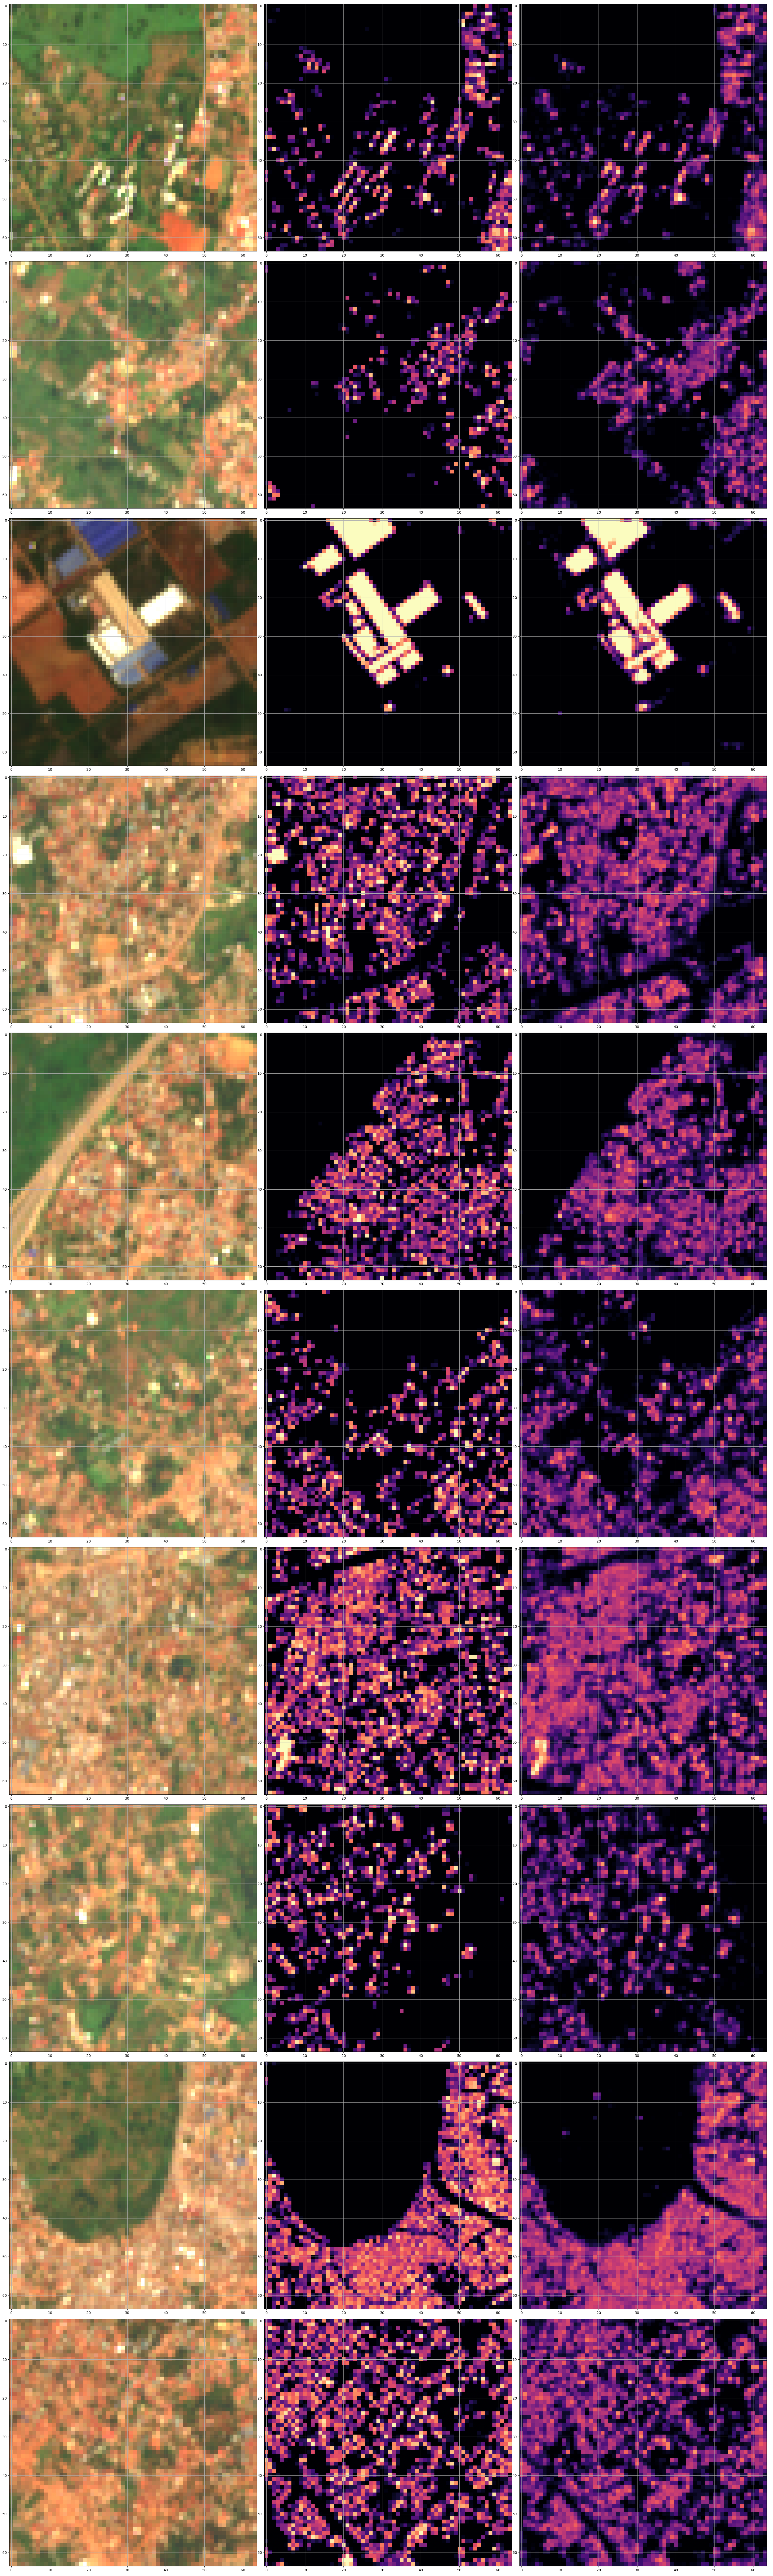

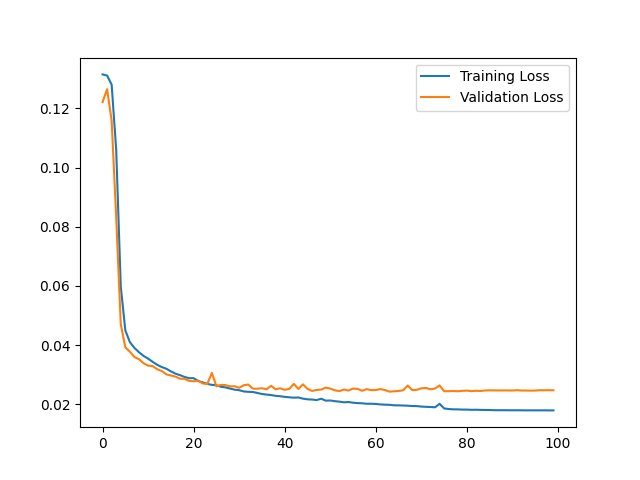

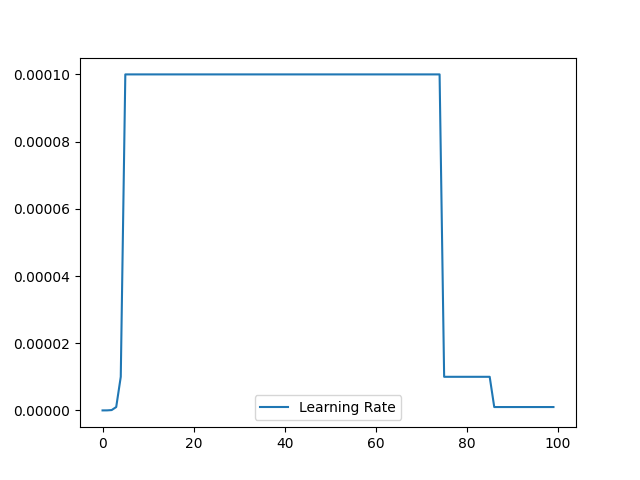

In [11]:
from IPython.display import display, Image
display(Image(filename= f'{OUTPUT_FOLDER}/visualisations/test_pred.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/loss.png'))
display(Image(filename= f'{OUTPUT_FOLDER}/lr.png'))